In [2]:
import torch
from torch import nn,optim,softmax
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from torch.nn.modules import flatten

In [3]:
# Get cpu or gpu device for training.
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

training_data = datasets.MNIST(root="./data", download=True,
                                      train=True, 
                                      transform=transforms.ToTensor())

test_data = datasets.MNIST(root="./data", download=True,
                                  train=False,
                                  transform=transforms.ToTensor())
# data is in [0; 1] (thanks to ToTensor()), but there is no "standardisation"


Using cpu device


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
batch_size = 32
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_data, batch_size=batch_size,shuffle=False, num_workers=2)

In [7]:
#Defining the convolutional layers and the neural network
class Neural_net(nn.Module):
  def __init__(self):
    super(Neural_net,self).__init__()

    # creating the 2D convolution layers
    self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1)

    #creating drop-out layers
    self.dc2= nn.Dropout(0.5)

    #Creating Max-Pooling 
    self.mp1= nn.MaxPool2d(2,stride=2)

    #Fully Connected layer mapping the output of the convolutional layers to 128
    self.fc1= nn.Linear(14*14*16,128)

    #Fully connected layers for 10 classes
    self.fc2 = nn.Linear(128, 10)

  def forward(self,X):
    relu = torch.nn.ReLU()

    #applying convlution and ReLU
    X = relu(self.conv1(X))
    X = relu(self.conv2(X))
    
    #applying Max pooling
    X=self.mp1(X)
    
    #Flattening the inputs
    X = X.reshape(-1,14*14*16)    
    X = relu(self.fc1(X))

    #applying drop out
    X = self.dc2(X)

    output = self.fc2(X)
    
    return output

In [8]:
model= Neural_net()
print(model)

Neural_net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dc2): Dropout(p=0.5, inplace=False)
  (mp1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [9]:
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.01,momentum=0.9)

In [10]:
def train_for_epoch():

    # putting model in train mode
    model.train()

    # keep track of the training losses during the epoch
    train_losses = []

    for batch, targets in train_dataloader:
        
        # clear previous gradient computation
        optimizer.zero_grad()

        # forward propagation
        predictions = model(batch)

        # calculate the loss
        loss = loss_func(predictions, targets)

        # backpropagate to compute gradients
        loss.backward()

        # update model weights
        optimizer.step()

        # update average loss
        train_losses.append(loss.item())

    # calculate average training loss
    train_loss = np.mean(train_losses)

    return train_loss

In [11]:
def train(first_epoch, num_epochs):
    
    train_losses = []

    for epoch in range(first_epoch, first_epoch + num_epochs):

        # training phase
        train_loss = train_for_epoch()      

        print(f'epoch: [{epoch:02d}] train loss: {train_loss:04f}')
        
        train_losses.append(train_loss)
    
    return train_losses

In [12]:
train_loss=train(1,20)

epoch: [01] train loss: 0.364978
epoch: [02] train loss: 0.113319
epoch: [03] train loss: 0.082500
epoch: [04] train loss: 0.066484
epoch: [05] train loss: 0.059663
epoch: [06] train loss: 0.049695
epoch: [07] train loss: 0.044171
epoch: [08] train loss: 0.038755
epoch: [09] train loss: 0.038126
epoch: [10] train loss: 0.034236
epoch: [11] train loss: 0.030757
epoch: [12] train loss: 0.027999
epoch: [13] train loss: 0.026466
epoch: [14] train loss: 0.025288
epoch: [15] train loss: 0.023764
epoch: [16] train loss: 0.023407
epoch: [17] train loss: 0.021446
epoch: [18] train loss: 0.019029
epoch: [19] train loss: 0.019647
epoch: [20] train loss: 0.018648


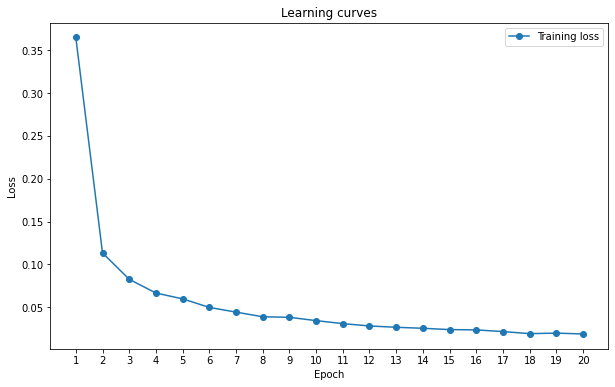

In [13]:
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, train_loss, '-o', label='Training loss')
plt.legend()
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.xticks(epochs)
plt.show()

In [14]:
def check_accuracy(dataloader):
  # putting model in evaluation mode
    model.eval()
    
    y_pred=[]

    with torch.no_grad():

      #go over each batch to determine model accuracy.

      for batch,_ in dataloader:
        
        # Predict probabilty of each class
        predictions = model(batch)

        #applying softmax on predictions
        predictions = softmax(predictions,dim=1)

        # convert to numpy
        predictions = predictions.numpy()

        # save
        y_pred.append(predictions)
    
    # stack predictions into a (num_samples, 10) array
    y_pred = np.vstack(y_pred)
    return y_pred
  

In [15]:
# compute predictions on the test set
y_pred = check_accuracy(test_dataloader)

# find the argmax of each of the predictions
y_pred = y_pred.argmax(axis=1)

# get the true labels and convert to numpy
y_true = np.array(test_data.targets)

 # Calculate accuracy as the average number of times y_true == y_pred
accuracy = np.mean(np.equal(y_pred,y_true))

print(accuracy)

0.9911


In [20]:
error_indicator = y_pred != y_true
error_examples = test_data.data[error_indicator, :, :]
sample = error_examples[:10]

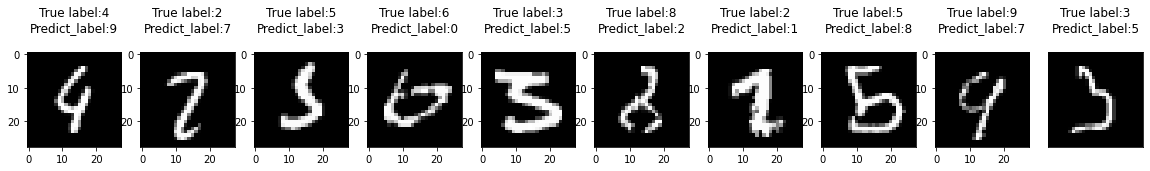

In [26]:
# 10 Worst classifications
fig, axes = plt.subplots(nrows=1, ncols=10, figsize=(20,20))
plt.grid(False)
plt.xticks([])
plt.yticks([])
for i in range(sample.shape[0]):
  axes[i].set_title('True label:'+str(y_true[error_indicator][i])+'\n''Predict_label:'+str(y_pred[error_indicator][i])+'\n')
  axes[i].imshow(sample[i,:,:],cmap='gray')
  
plt.show()